In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.pyplot as plt
import numpy as np

2025-09-28 10:13:56.901539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759054437.137598      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759054437.206224      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 1)


I0000 00:00:1759054464.583164      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


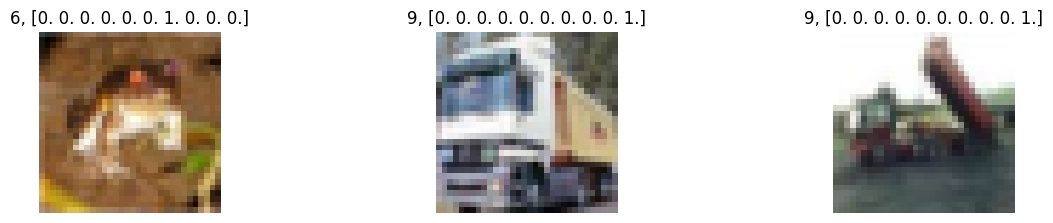

In [2]:
# -------------------------
# 1. Load CIFAR-10 dataset
# -------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
x_train_small = x_train[:5000]
y_train_small = y_train[:5000]
x_test_small = x_test[:1000]
y_test_small = y_test[:1000]
x_train = x_train_small
y_train = y_train_small
y_test = y_test_small
x_test = x_test_small
train_images=x_train
train_labels=y_train.flatten()
plt.figure(figsize=(20, 20))
plot_index = 1
num_images = 3  # Number of images to plot

for i in range(num_images):
    plt.subplot(10, 10, plot_index)  # Adjust grid to fit images
    plt.imshow(train_images[i], cmap="gray")
    plt.title(f"{train_labels[i]}, {tf.one_hot(train_labels[i], 10)}")
    plt.axis("off")
    plot_index += 2

plt.tight_layout()
plt.show()

NUM_CLASSES = 10
IMG_SIZE = (224, 224)   # ResNet50 expects 224x224
BATCH_SIZE = 64

# one-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

In [3]:
# -------------------------
# 2. Preprocess: resize and normalize using tf.data
# -------------------------
def preprocess(images, labels):
    images = tf.image.resize(images, IMG_SIZE)
    images = preprocess_input(images)  # VGG16 preprocessing
    return images, labels

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(BATCH_SIZE).map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).map(preprocess).prefetch(tf.data.AUTOTUNE)


In [4]:
# -------------------------
# 3. Build model: ResNet50 base + custom head
# -------------------------
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False   # Phase A: freeze all

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
1e-2

0.01

In [6]:
# -------------------------
# 4. Compile and train head
# -------------------------
model.compile(optimizer=optimizers.Adamax(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_head = model.fit(train_ds, validation_data=val_ds, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5


I0000 00:00:1759054480.954916      59 service.cc:148] XLA service 0x79787c013c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759054480.955851      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759054482.462689      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/79 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.1406 - loss: 3.6806  

I0000 00:00:1759054488.077669      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 270ms/step - accuracy: 0.4070 - loss: 1.9955 - val_accuracy: 0.7970 - val_loss: 0.6134
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.7138 - loss: 0.8101 - val_accuracy: 0.8280 - val_loss: 0.4952
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.7671 - loss: 0.6797 - val_accuracy: 0.8460 - val_loss: 0.4509
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.7785 - loss: 0.6425 - val_accuracy: 0.8530 - val_loss: 0.4262
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8056 - loss: 0.5714 - val_accuracy: 0.8620 - val_loss: 0.4116


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 27.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


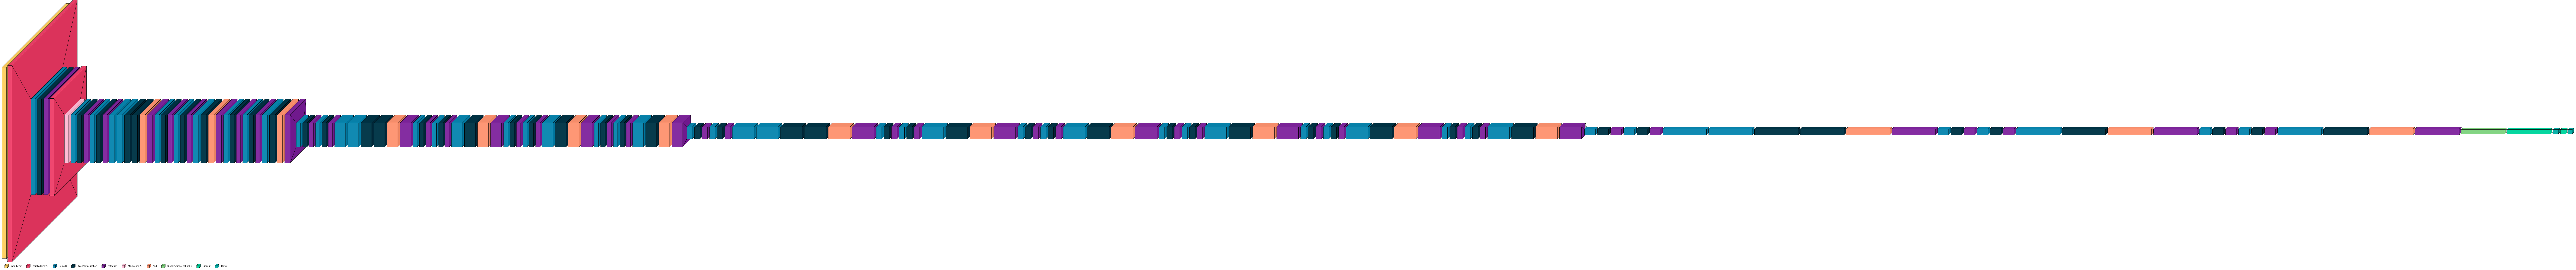

"dot" with args ['-Tpng', '/tmp/tmp61t2_ojo/tmpq1qmshyj'] returned code: -6

stdout, stderr:
 b''
b"failed at node 10634[1]\ndot: maze.c:313: chkSgraph: Assertion `np->cells[1]' failed.\n"

plot_model error (needs graphviz/pydot): "dot" with args ['-Tpng', '/tmp/tmp61t2_ojo/tmpq1qmshyj'] returned code: -6


In [7]:
# Visualize the model architecture with visualkeras and tf.keras.utils.plot_model
try:
    import visualkeras
except Exception:
    # in a Jupyter notebook use %pip; fallback uses sys.executable for script contexts
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "visualkeras", "graphviz", "pydot"])
    import visualkeras
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
import os

# 1) visualkeras layered view (PIL image saved)
try:
    visualkeras.layered_view(model, legend=True, to_file="model_visual.png")
    if os.path.exists("model_visual.png"):
        display(Image("model_visual.png"))
except Exception as e:
    print("visualkeras error:", e)

# 2) Keras plot_model (requires graphviz + pydot)
try:
    plot_model(model, to_file="model_graph.png", show_shapes=True, show_layer_names=True)
    if os.path.exists("model_graph.png"):
        display(Image("model_graph.png"))
except Exception as e:
    print("plot_model error (needs graphviz/pydot):", e)


In [8]:
model.evaluate(val_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8576 - loss: 0.4233


[0.4116345942020416, 0.8619999885559082]

In [9]:
# Show model config
model.get_config()

{'name': 'functional',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None,
   'name': 'input_layer',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': False,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'registered_name': None,
   'build_config': {'input_shape': (None, 224, 224, 3)},
   'name': 'conv1_pad',
   'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__',
       'config': {'shape': (None, 224, 224, 3),
        'dtype': 'float32',
        'keras_history': ['input_layer', 0, 0]}},),
     'kwargs': {}}]},
  {'module': 'keras.layers',
   'c

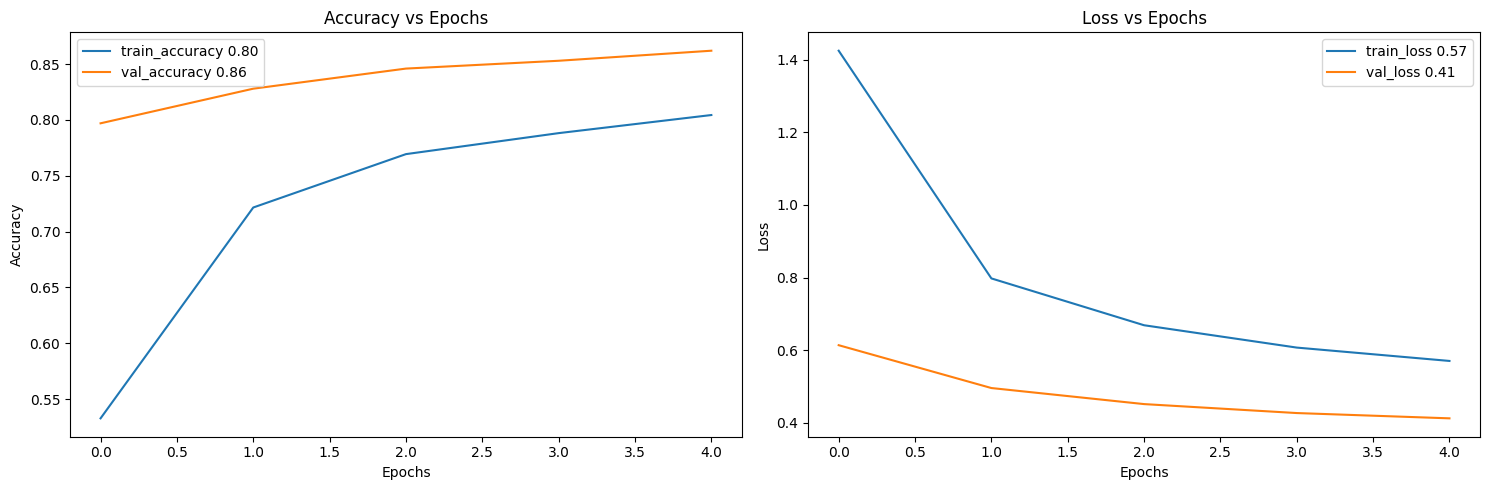

In [10]:
def sub_plot_graph(history, title1, title2):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f"train_accuracy {history.history['accuracy'][-1]:.2f}")
    plt.plot(history.history['val_accuracy'], label=f"val_accuracy {history.history['val_accuracy'][-1]:.2f}")
    plt.title(title1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f"train_loss {history.history['loss'][-1]:.2f}")
    plt.plot(history.history['val_loss'], label=f"val_loss {history.history['val_loss'][-1]:.2f}")
    plt.title(title2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

sub_plot_graph(history_head, "Accuracy vs Epochs", "Loss vs Epochs")

In [11]:
len(model.layers)

180

In [12]:
len(base_model.layers)

175

In [13]:
def unfreeze_slice(index):
    for i, layer in enumerate(base_model.layers[index:]):
        layer.trainable = True
        print(f"Unfrozen: {layer.name} (index {index + i})")


=== Unfreezing last 1 layers ===
Unfrozen: conv5_block3_out (index 174)
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 233ms/step - accuracy: 0.8128 - loss: 0.5341 - val_accuracy: 0.8710 - val_loss: 0.3885
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.8236 - loss: 0.4982 - val_accuracy: 0.8680 - val_loss: 0.3820
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8227 - loss: 0.4973 - val_accuracy: 0.8760 - val_loss: 0.3722
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8300 - loss: 0.4754 - val_accuracy: 0.8740 - val_loss: 0.3750
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.8409 - loss: 0.4615 - val_accuracy: 0.8760 - val_loss: 0.3693
Validation loss: 0.3693, Validation accuracy: 0.8760


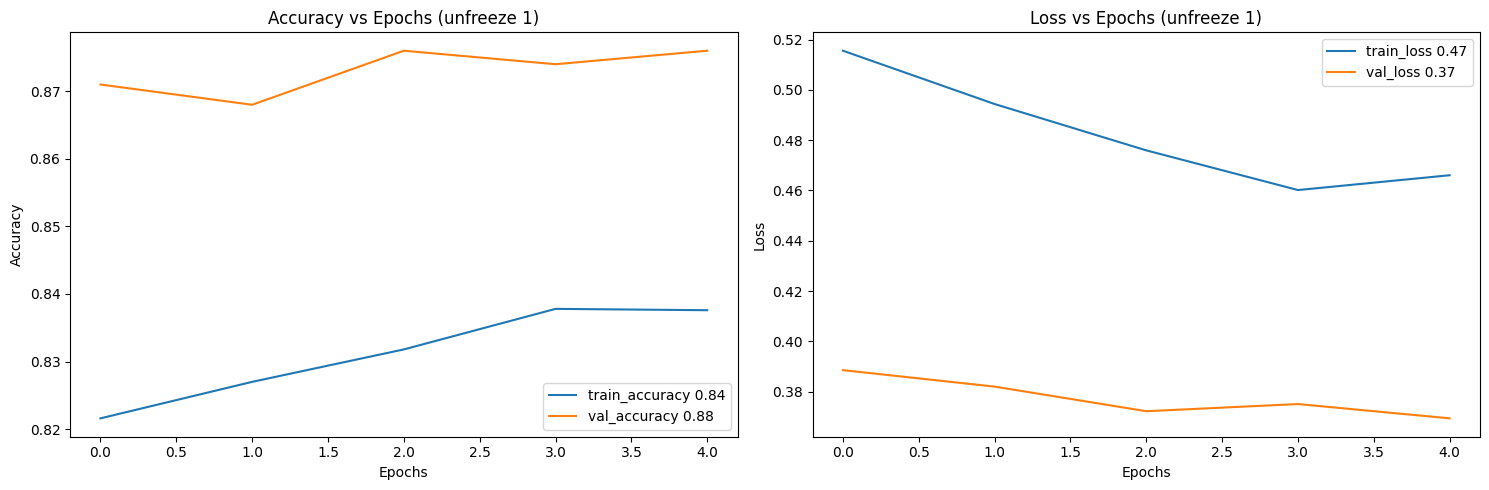


=== Unfreezing last 2 layers ===
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 227ms/step - accuracy: 0.8492 - loss: 0.4522 - val_accuracy: 0.8730 - val_loss: 0.3664
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8546 - loss: 0.4172 - val_accuracy: 0.8770 - val_loss: 0.3601
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8579 - loss: 0.4194 - val_accuracy: 0.8770 - val_loss: 0.3622
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8525 - loss: 0.4276 - val_accuracy: 0.8790 - val_loss: 0.3549
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8685 - loss: 0.4007 - val_accuracy: 0.8850 - val_loss: 0.3515
Validation loss: 0.3515, Validation accuracy: 0.8850


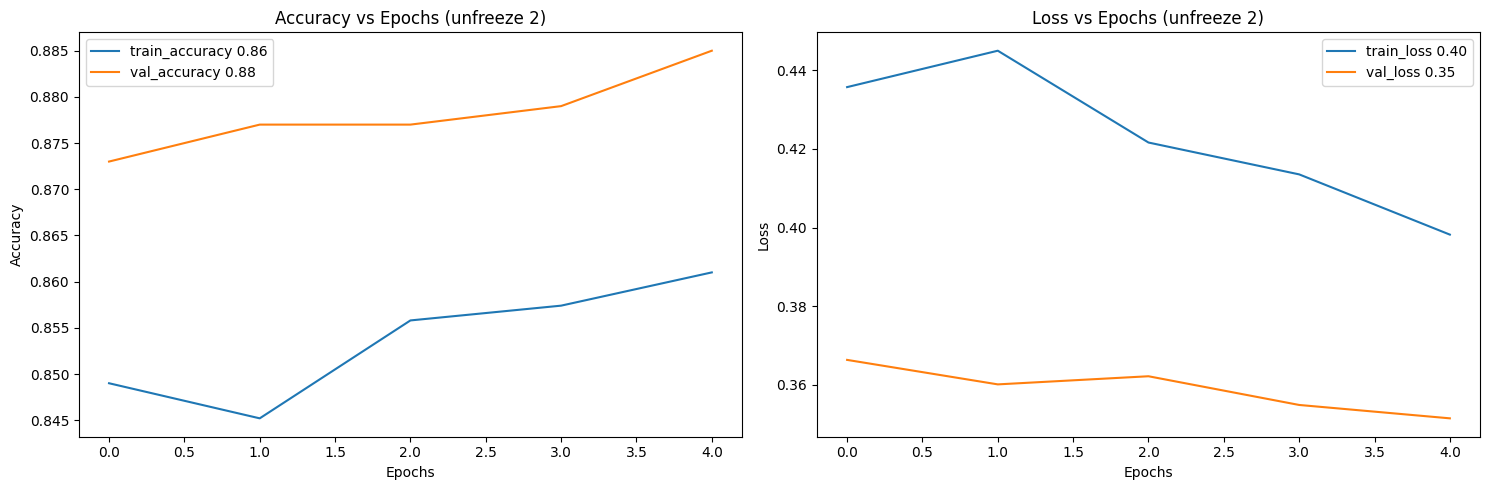


=== Unfreezing last 3 layers ===
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - accuracy: 0.8625 - loss: 0.3906 - val_accuracy: 0.8760 - val_loss: 0.3537
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8751 - loss: 0.3662 - val_accuracy: 0.8830 - val_loss: 0.3455
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8702 - loss: 0.3792 - val_accuracy: 0.8750 - val_loss: 0.3455
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8774 - loss: 0.3574 - val_accuracy: 0.8780 - val_loss: 0.3461
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8820 - loss: 0.3361 - val_accuracy: 0.8830 - val_loss: 0.3402
Validation loss: 0.3402, Validation accuracy: 0.8830


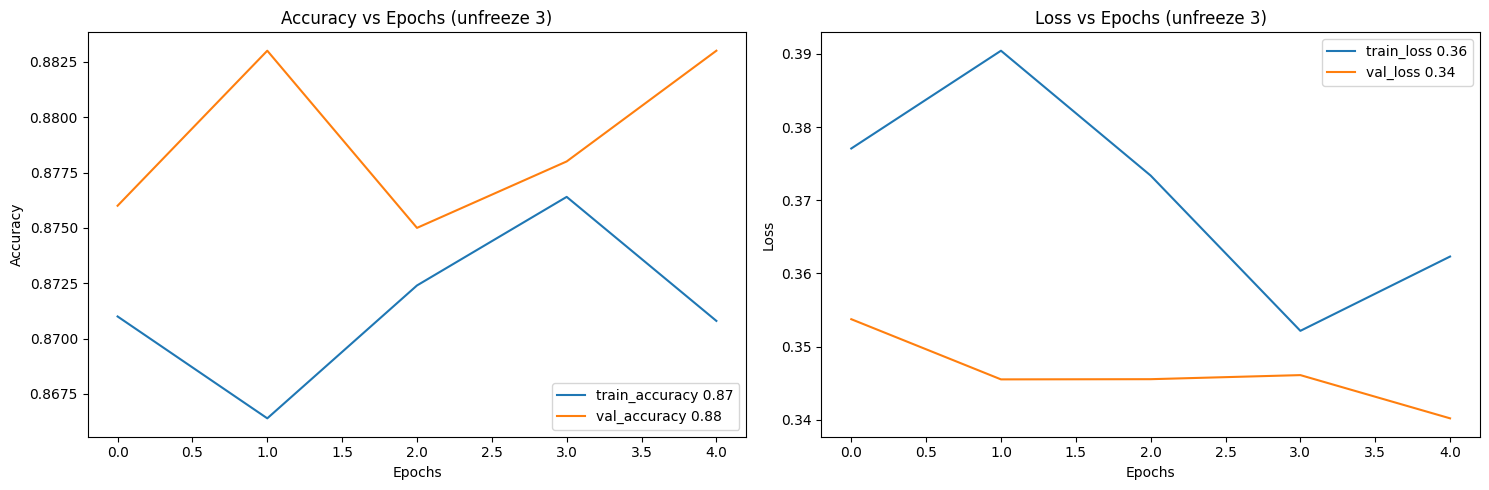


=== Unfreezing last 4 layers ===
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 240ms/step - accuracy: 0.8816 - loss: 0.3555 - val_accuracy: 0.8830 - val_loss: 0.3474
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.8992 - loss: 0.2860 - val_accuracy: 0.8870 - val_loss: 0.3313
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9010 - loss: 0.2736 - val_accuracy: 0.8800 - val_loss: 0.3360
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9100 - loss: 0.2735 - val_accuracy: 0.8830 - val_loss: 0.3337
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9115 - loss: 0.2401 - val_accuracy: 0.8800 - val_loss: 0.3448
Validation loss: 0.3448, Validation accuracy: 0.8800


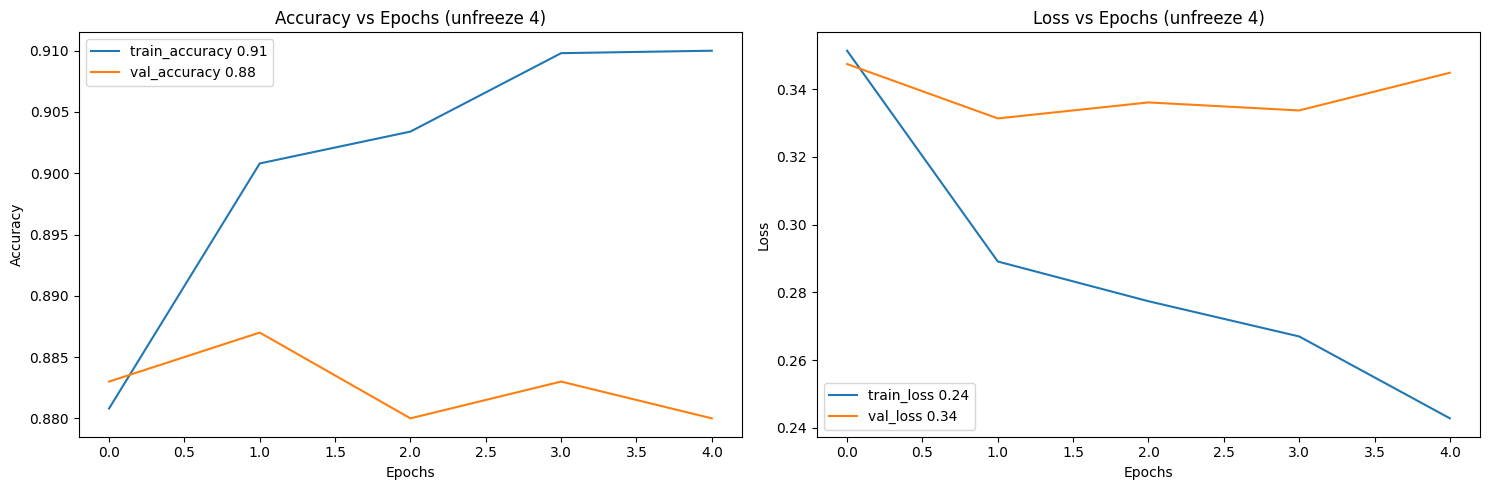


=== Unfreezing last 5 layers ===
Unfrozen: conv5_block3_2_relu (index 170)
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 235ms/step - accuracy: 0.9213 - loss: 0.2172 - val_accuracy: 0.8890 - val_loss: 0.3365
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.9316 - loss: 0.1891 - val_accuracy: 0.8890 - val_loss: 0.3491
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9364 - loss: 0.1761 - val_accuracy: 0.8920 - val_loss: 0.3458
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.9502 - loss: 0.1480 - val_accuracy: 0.8900 - val_loss: 0.3432
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9476 - loss: 0.1506 - val_accuracy: 0.8920 - val_loss: 0.3552
Validation loss: 0.3552, Validation accuracy: 0.8920


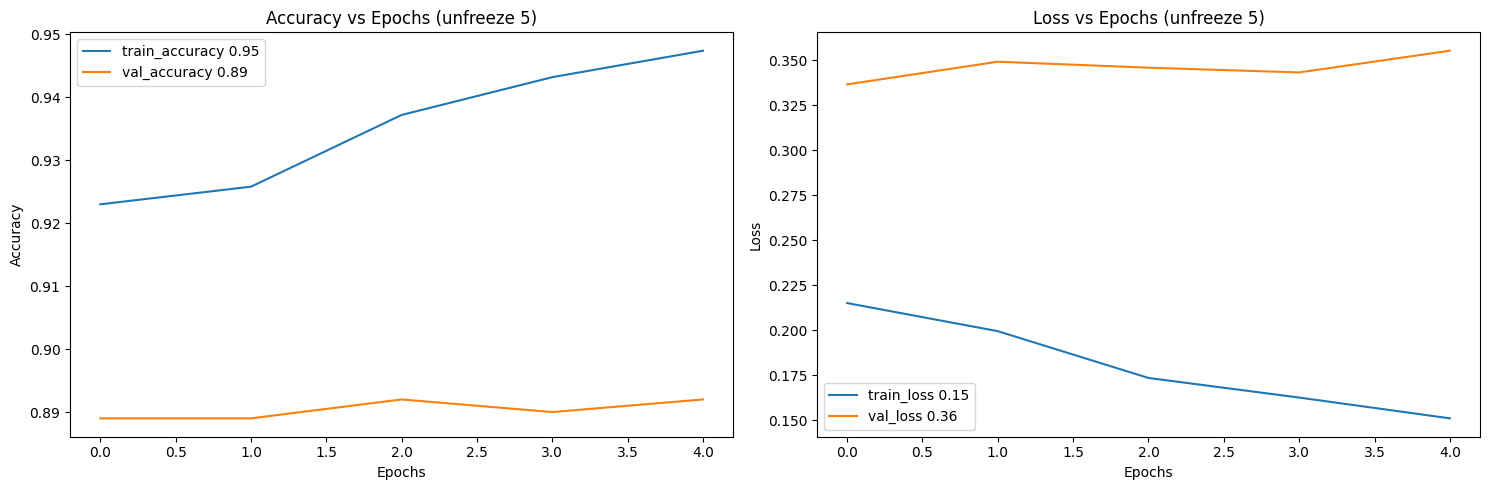


=== Unfreezing last 6 layers ===
Unfrozen: conv5_block3_2_bn (index 169)
Unfrozen: conv5_block3_2_relu (index 170)
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 236ms/step - accuracy: 0.9481 - loss: 0.1551 - val_accuracy: 0.8900 - val_loss: 0.3605
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9475 - loss: 0.1515 - val_accuracy: 0.8880 - val_loss: 0.3545
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9530 - loss: 0.1349 - val_accuracy: 0.8890 - val_loss: 0.3564
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.9581 - loss: 0.1177 - val_accuracy: 0.8940 - val_loss: 0.3516
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.9620 - loss: 0.1067 - val_accuracy: 0.8860 - val_loss: 0.3710
Validation loss: 0.3710, Validation accuracy: 0.8860


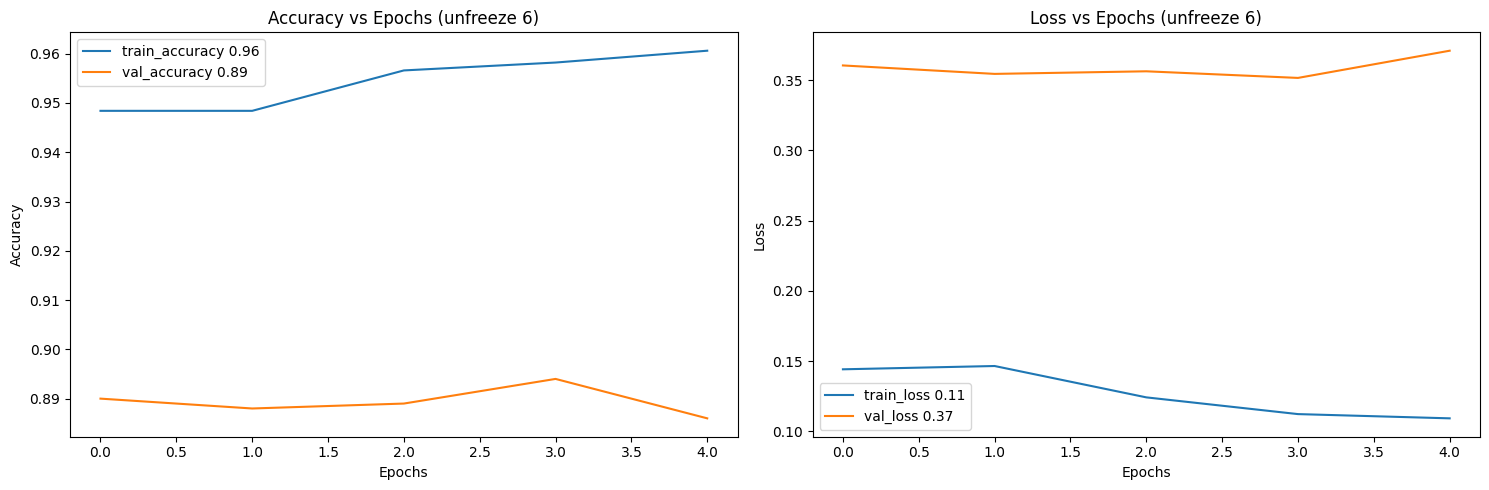


=== Unfreezing last 7 layers ===
Unfrozen: conv5_block3_2_conv (index 168)
Unfrozen: conv5_block3_2_bn (index 169)
Unfrozen: conv5_block3_2_relu (index 170)
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 241ms/step - accuracy: 0.9676 - loss: 0.0961 - val_accuracy: 0.8880 - val_loss: 0.4119
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.9682 - loss: 0.0880 - val_accuracy: 0.8850 - val_loss: 0.4163
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.9821 - loss: 0.0631 - val_accuracy: 0.8860 - val_loss: 0.4244
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.9822 - loss: 0.0503 - val_accuracy: 0.8850 - val_loss: 0.4208
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.9881 - loss: 0.0414 - val_accuracy: 0.8990 - val_loss: 0.4201
Validation loss: 0.4201, Validation accuracy

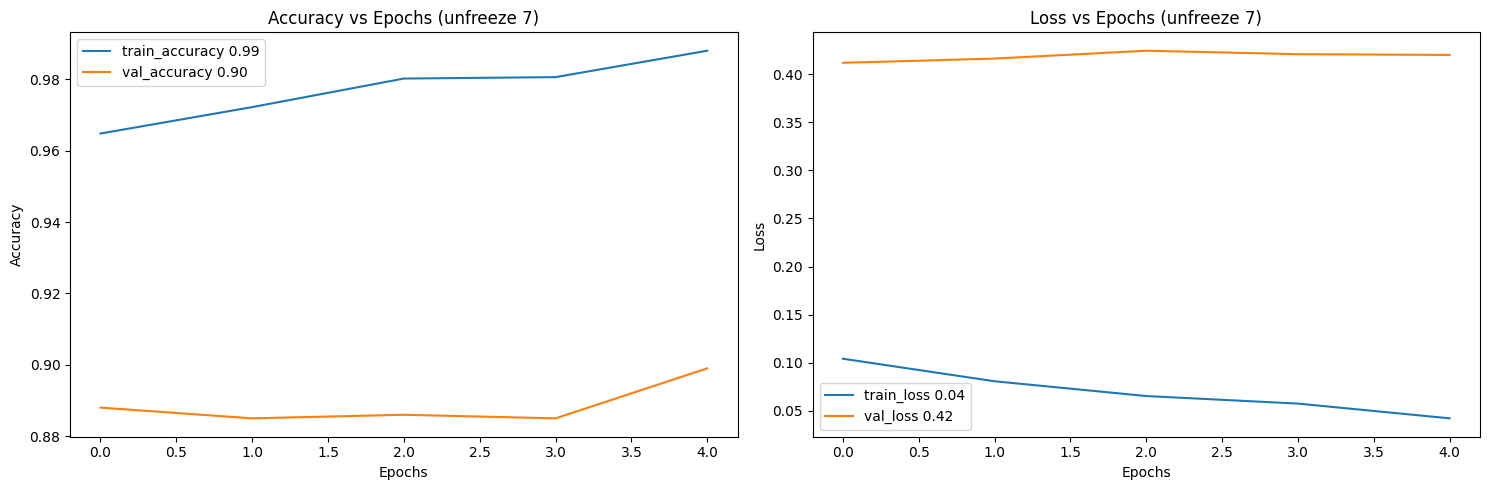


=== Unfreezing last 8 layers ===
Unfrozen: conv5_block3_1_relu (index 167)
Unfrozen: conv5_block3_2_conv (index 168)
Unfrozen: conv5_block3_2_bn (index 169)
Unfrozen: conv5_block3_2_relu (index 170)
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 247ms/step - accuracy: 0.9901 - loss: 0.0358 - val_accuracy: 0.8890 - val_loss: 0.4552
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.9913 - loss: 0.0312 - val_accuracy: 0.8870 - val_loss: 0.4626
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9918 - loss: 0.0277 - val_accuracy: 0.8800 - val_loss: 0.4634
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9899 - loss: 0.0257 - val_accuracy: 0.8910 - val_loss: 0.4827
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.9915 - loss: 0.0228 - val_accuracy: 0.8880 - val_loss: 0.5027
Va

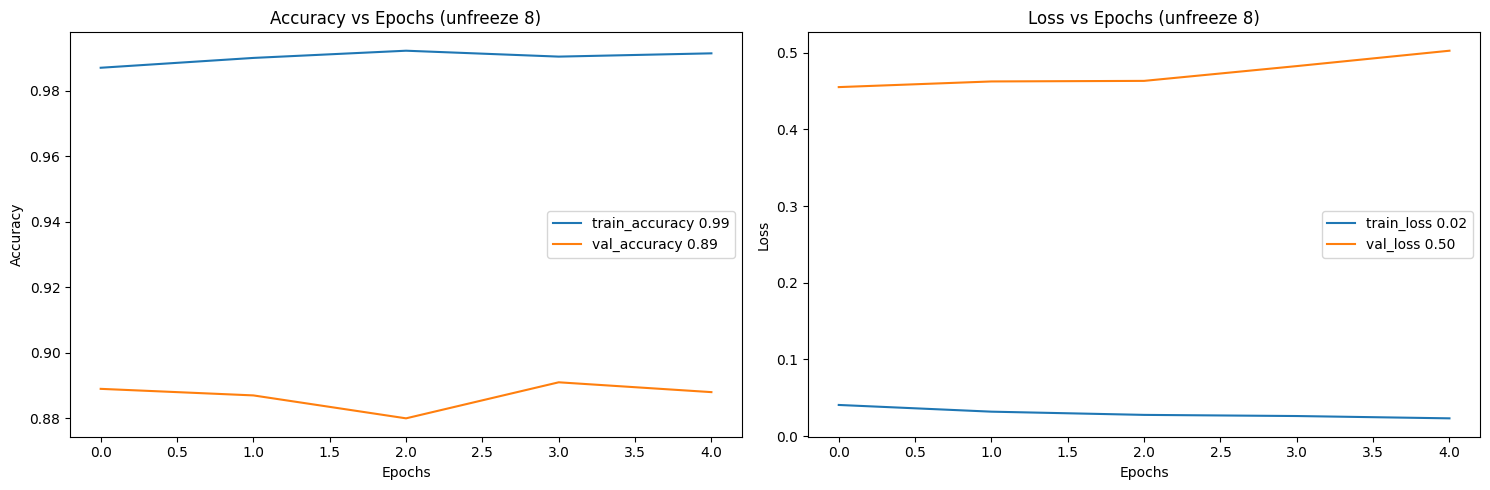


=== Unfreezing last 9 layers ===
Unfrozen: conv5_block3_1_bn (index 166)
Unfrozen: conv5_block3_1_relu (index 167)
Unfrozen: conv5_block3_2_conv (index 168)
Unfrozen: conv5_block3_2_bn (index 169)
Unfrozen: conv5_block3_2_relu (index 170)
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 251ms/step - accuracy: 0.9949 - loss: 0.0186 - val_accuracy: 0.8790 - val_loss: 0.5647
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.9939 - loss: 0.0205 - val_accuracy: 0.8810 - val_loss: 0.5965
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9958 - loss: 0.0145 - val_accuracy: 0.8900 - val_loss: 0.5979
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9960 - loss: 0.0157 - val_accuracy: 0.8760 - val_loss: 0.6253
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9952 - loss: 0.0137 - v

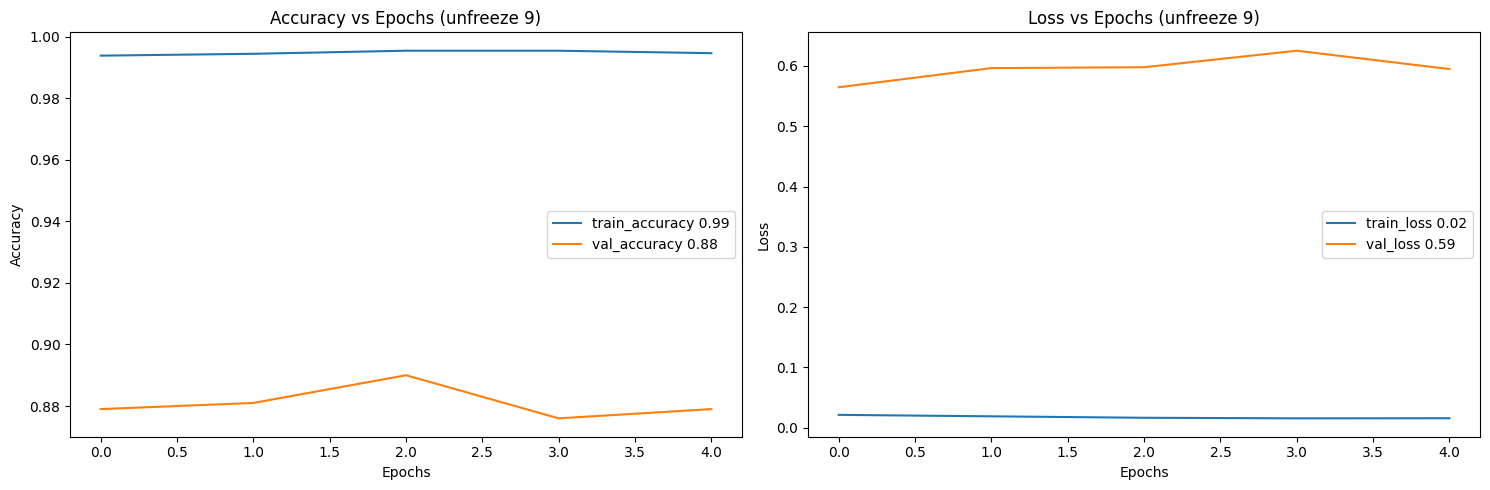


=== Unfreezing last 10 layers ===
Unfrozen: conv5_block3_1_conv (index 165)
Unfrozen: conv5_block3_1_bn (index 166)
Unfrozen: conv5_block3_1_relu (index 167)
Unfrozen: conv5_block3_2_conv (index 168)
Unfrozen: conv5_block3_2_bn (index 169)
Unfrozen: conv5_block3_2_relu (index 170)
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 246ms/step - accuracy: 0.9945 - loss: 0.0141 - val_accuracy: 0.8810 - val_loss: 0.7180
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9976 - loss: 0.0113 - val_accuracy: 0.8780 - val_loss: 0.6795
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9957 - loss: 0.0146 - val_accuracy: 0.8830 - val_loss: 0.6732
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9932 - loss: 0.0190 - val_accuracy: 0.8790 - val_loss: 0.6658
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 119m

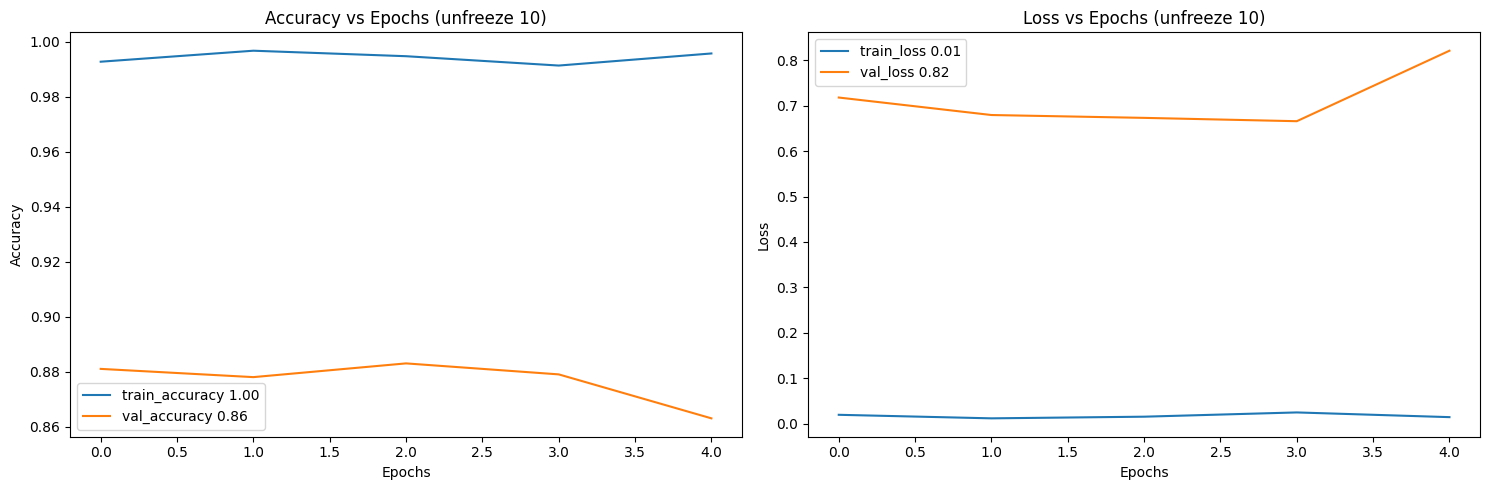

In [14]:
histories = {}

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Loop over different numbers of layers to unfreeze
for num_layers_to_unfreeze in range(1, 11):  # unfreeze last 1 to 10 layers
    print(f"\n=== Unfreezing last {num_layers_to_unfreeze} layers ===")

    # Freeze everything again to reset
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last `num_layers_to_unfreeze` layers
    for i, layer in enumerate(base_model.layers[-num_layers_to_unfreeze:]):
        layer.trainable = True
        print(f"Unfrozen: {layer.name} (index {len(base_model.layers)-num_layers_to_unfreeze+i})")

    # Recompile after changing trainability
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    # Store history
    histories[f"unfreeze_{num_layers_to_unfreeze}"] = history

    # Evaluate
    results = model.evaluate(val_ds, verbose=0)
    print(f"Validation loss: {results[0]:.4f}, Validation accuracy: {results[1]:.4f}")

    # Plot curves for this experiment
    sub_plot_graph(
        history,
        f"Accuracy vs Epochs (unfreeze {num_layers_to_unfreeze})",
        f"Loss vs Epochs (unfreeze {num_layers_to_unfreeze})"
    )

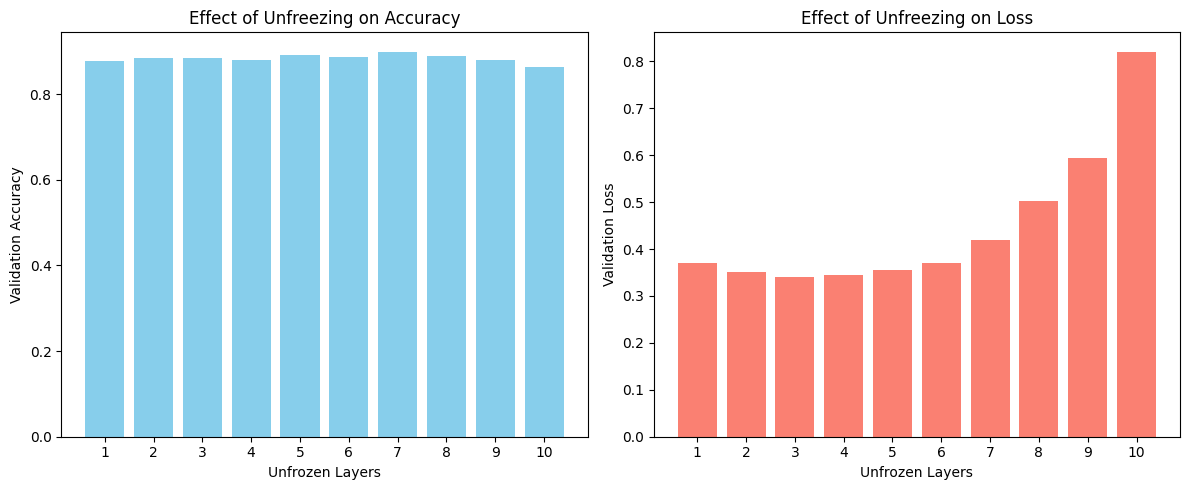

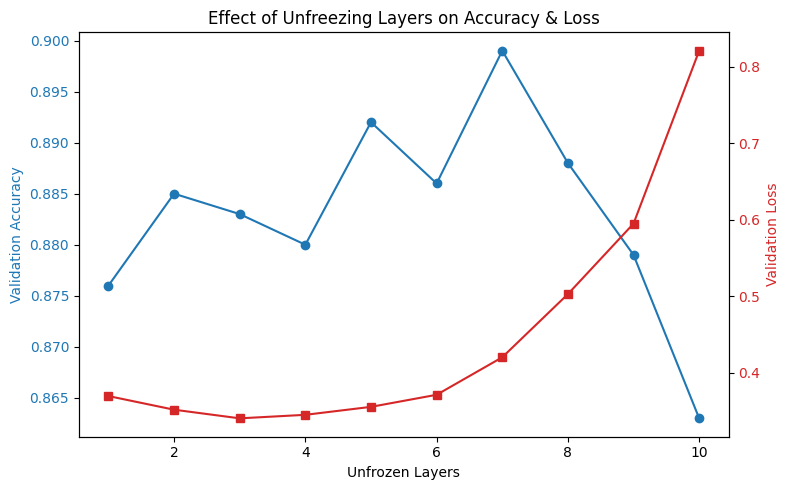

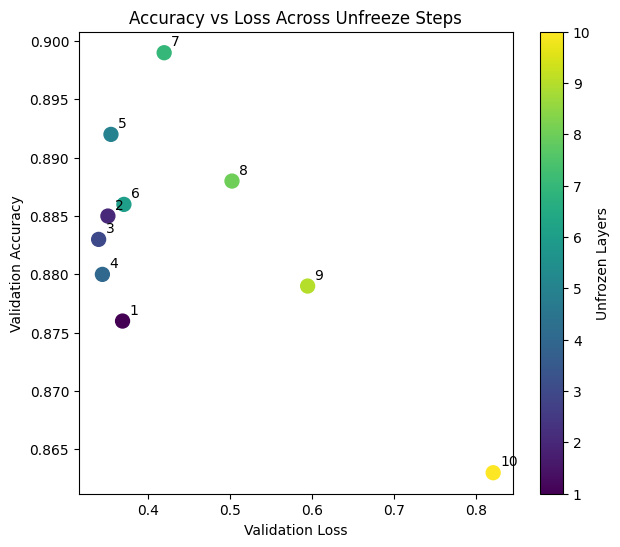

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Collect results from histories
unfreeze_counts = []
final_val_acc = []
final_val_loss = []

for key, history in histories.items():
    unfreeze_num = int(key.split("_")[1])  
    acc = history.history["val_accuracy"][-1]
    loss = history.history["val_loss"][-1]

    unfreeze_counts.append(unfreeze_num)
    final_val_acc.append(acc)
    final_val_loss.append(loss)

# Sort results by number of unfrozen layers
order = np.argsort(unfreeze_counts)
unfreeze_counts = np.array(unfreeze_counts)[order]
final_val_acc = np.array(final_val_acc)[order]
final_val_loss = np.array(final_val_loss)[order]

# --- 1. Side-by-side Bar Charts (Accuracy & Loss) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(unfreeze_counts, final_val_acc, color="skyblue")
axes[0].set_xlabel("Unfrozen Layers")
axes[0].set_ylabel("Validation Accuracy")
axes[0].set_title("Effect of Unfreezing on Accuracy")
axes[0].set_xticks(unfreeze_counts)

axes[1].bar(unfreeze_counts, final_val_loss, color="salmon")
axes[1].set_xlabel("Unfrozen Layers")
axes[1].set_ylabel("Validation Loss")
axes[1].set_title("Effect of Unfreezing on Loss")
axes[1].set_xticks(unfreeze_counts)

plt.tight_layout()
plt.show()

# --- 2. Dual-axis Line Plot (Accuracy + Loss vs Layers) ---
fig, ax1 = plt.subplots(figsize=(8,5))

color = "tab:blue"
ax1.set_xlabel("Unfrozen Layers")
ax1.set_ylabel("Validation Accuracy", color=color)
ax1.plot(unfreeze_counts, final_val_acc, marker="o", color=color, label="Val Accuracy")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Validation Loss", color=color)
ax2.plot(unfreeze_counts, final_val_loss, marker="s", color=color, label="Val Loss")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Effect of Unfreezing Layers on Accuracy & Loss")
fig.tight_layout()
plt.show()

# --- 3. Scatter Plot (Accuracy vs Loss Trade-off) ---
plt.figure(figsize=(7,6))
plt.scatter(final_val_loss, final_val_acc, c=unfreeze_counts, cmap="viridis", s=100)
for i, txt in enumerate(unfreeze_counts):
    plt.annotate(txt, (final_val_loss[i], final_val_acc[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel("Validation Loss")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Loss Across Unfreeze Steps")
plt.colorbar(label="Unfrozen Layers")
plt.show()


In [16]:
# -------------------------
# 5. Progressive unfreezing (block by block)
# -------------------------
'''def unfreeze_block(block_num):
    for layer in base_model.layers:
        if f'block{block_num}_' in layer.name:
            layer.trainable = True

blocks_to_unfreeze = [5, 4]  # you can add 3, 2, 1 for deeper fine-tuning
fine_tune_histories = []

for block in blocks_to_unfreeze:
    print(f"\n--- Unfreezing block {block} ---")
    unfreeze_block(block)
    model.compile(optimizer=optimizers.Adam(1e-5),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    hist = model.fit(train_ds, validation_data=val_ds, epochs=3)
    fine_tune_histories.append(hist)'''
    
# -------------------------
# Unfreeze a slice of layers
# -------------------------
'''def unfreeze_slice(start=None, end=None):
    """
    Unfreezes layers[start:end] (Python slicing rules).
    Example:
        unfreeze_slice(4, None)   # unfreeze from layer 4 to the end
        unfreeze_slice(None, 4)   # unfreeze first 4 layers
    """
    for i, layer in enumerate(base_model.layers[start:end]):
        layer.trainable = True
        #layer.trainable = False
        print(f"Unfrozen: {layer.name} (index {i})")

unfreeze_slice(15,None)'''

'def unfreeze_slice(start=None, end=None):\n    """\n    Unfreezes layers[start:end] (Python slicing rules).\n    Example:\n        unfreeze_slice(4, None)   # unfreeze from layer 4 to the end\n        unfreeze_slice(None, 4)   # unfreeze first 4 layers\n    """\n    for i, layer in enumerate(base_model.layers[start:end]):\n        layer.trainable = True\n        #layer.trainable = False\n        print(f"Unfrozen: {layer.name} (index {i})")\n\nunfreeze_slice(15,None)'